# Cytof data processing

## Requirements

For compatibility, the `numpy` version needs to be fixed:
```bash
pip3 install --upgrade pandas numpy==1.26.4 scprep phate
```

## Variables definition

In [3]:
# Specify the folder containing data to analyse
folder_path = "./test_cytof_data"

# Specify the metadata columns
metadata_columns = ['Cell_Index', 'Condition', 'Control', 'Replicate']

# Specify other columns to exclude from processing
excluded_columns = []

# Compute the non data columns in a new variable for easier later use
non_data_columns = excluded_columns + metadata_columns

## Import common packages

In [4]:
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 1000)

## Concatenate all files

### Configuration

In [5]:
get_condition_replicate_from_filename = True

### Concatenate

In [6]:
all_events = pd.DataFrame()

# Loop over all files in folder
for filename in os.listdir(folder_path):
    # Only consider files with '.txt' extension
    if filename.endswith('.txt'):
        # Build the full path to file
        file_path = os.path.join(folder_path, filename)
        # Load the file
        events = pd.read_csv(file_path, delimiter='\t')

        if get_condition_replicate_from_filename:
            # Retrieve metadata from the filename (ex: WGANormalised_Pro_PDO21 + CAFs_01.fcs_file_internal...)
            # First split: ['WGANormalised_Pro_PDO21 + CAFs_01', '_file_internal']
            # Second split over first element: ['WGANormalised', 'Pro', 'PDO21', '01']
            metadata_from_filename = filename.split('.fcs')[0].split('_')
            replicate = metadata_from_filename[-1]
            # Store the condition name in the dataframe: second-to-last element
            events['Condition'] = metadata_from_filename[-2] + '_' + replicate
            # Store the control name in the dataframe: second-to-last element split over '+', and stripped to remove whitespace from both sides
            events['Control'] = metadata_from_filename[-2].split('+')[0].strip()
            # Store the replicate in the dataframe: last element
            events['Replicate'] = replicate

        # Add the file data to the DataFrame containing all events
        all_events = pd.concat([all_events, events], ignore_index=True)

# Print all events
all_events

,Cell_Index,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],Condition,Control,Replicate
0,1,43.585557,1213.959853,3558.386958,0.000000,1458.946308,421.249051,707.013792,478.102051,112.645929,603.746433,50897.801994,1594.755375,53993.672474,10.087679,28051.093144,1690.470631,394.401844,1997.347396,31736.874224,365.299426,630.263993,6095.601789,3.853920e+04,2672.376730,46715.681153,372.530023,1727.848742,4939.136139,251.864645,15661.175919,979.785837,13075.133833,1090.477880,2.310142e+03,0.004876,390.414788,724.547763,11229.491117,438.423305,838.639540,102.624017,2751.651199,1059.449506,2758.233772,1.783434e+05,3.267123e+05,1.320918e+04,PDO21 + hIL8 12.5ng_02,PDO21,02
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,1106.766267,483.146464,0.000000,0.000000,6212.441179,112524.540240,3376.703678,63105.115731,2026.345475,78076.598058,5378.106523,3483.206300,14774.307667,16404.612777,0.000000,6325.650928,15999.116990,9.359513e+04,19611.374816,114839.243925,7337.893752,3590.558857,51435.443529,1505.413488,38390.718929,5494.854223,51952.686435,6593.492500,9.707502e+03,0.000554,3019.134512,583.799483,57342.426824,0.000000,9371.121594,253.987820,12415.285065,1217.250647,3465.030644,1.138082e+06,2.033536e+06,1.273348e+05,PDO21 + hIL8 12.5ng_02,PDO21,02
2,3,0.000000,0.000000,0.000000,1731.737952,3995.250069,562.508254,0.000000,181.267014,0.000000,211.807458,86705.838045,2220.989030,39521.113254,449.903746,5294.075421,7258.527181,2360.692782,2230.335842,4746.109479,3430.414044,2534.428668,23916.033206,5.296711e+04,4278.013643,25919.317740,218.391683,1234.880145,13760.759509,1343.636866,15913.337755,2911.830422,26219.449966,6317.144171,3.358493e+05,0.001748,328.106387,39.487448,22343.036966,1658.007231,2055.223981,0.000000,2376.693641,3997.301349,1056.888078,4.014445e+05,7.436298e+05,5.654798e+04,PDO21 + hIL8 12.5ng_02,PDO21,02
3,4,0.000000,2672.189928,0.000000,94.561986,0.000000,0.000000,2129.264680,0.000000,0.000000,0.000000,49121.290729,443.273420,66948.519779,434.657481,0.000000,0.000000,5211.869347,993.812809,1650.902655,0.000000,3786.186858,8147.540472,6.239263e+04,17666.475488,57566.085523,1134.561648,5410.785732,14088.210476,602.732347,155766.258197,3576.587010,23858.022486,3329.592530,1.212069e+04,0.000901,4550.623410,8163.213997,1948.253067,0.000000,3575.725906,0.000000,1061.280373,0.000000,3629.147982,7.199613e+05,1.275512e+06,3.018831e+05,PDO21 + hIL8 12.5ng_02,PDO21,02
4,5,0.000000,8911.913747,0.000000,22469.635814,1624.563602,7755.338861,0.000000,8886.237503,0.000000,0.000000,790518.367838,26739.996798,392637.619681,0.000000,170897.126636,7479.105856,25645.619233,52787.568714,53050.173847,23978.255141,5048.944674,113671.838662,1.089417e+06,217428.443030,501488.031274,0.000000,6905.471330,137955.596855,0.000000,269985.782167,129138.747335,536115.645320,58814.594023,7.214307e+06,0.000078,10430.904898,58470.340866,44148.812264,6660.390475,5337.305140,0.000000,36145.172415,40954.813217,65518.278247,7.275846e+06,1.301274e+07,1.797610e+06,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,3477,362.390948,992.681035,2068.121114,260.349544,316.508499,0.000000,298.312521,0

## EMD Generation

### Prepare the data

In [7]:
#drop the metadata to create a df with only numerical data for normalisation/transformation
data = all_events.drop(non_data_columns ,axis=1)
data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4]
0,43.585557,1213.959853,3558.386958,0.000000,1458.946308,421.249051,707.013792,478.102051,112.645929,603.746433,50897.801994,1594.755375,53993.672474,10.087679,28051.093144,1690.470631,394.401844,1997.347396,31736.874224,365.299426,630.263993,6095.601789,3.853920e+04,2672.376730,46715.681153,372.530023,1727.848742,4939.136139,251.864645,15661.175919,979.785837,13075.133833,1090.477880,2.310142e+03,0.004876,390.414788,724.547763,11229.491117,438.423305,838.639540,102.624017,2751.651199,1059.449506,2758.233772,1.783434e+05,3.267123e+05,1.320918e+04
1,0.000000,0.000000,0.000000,0.000000,0.000000,1106.766267,483.146464,0.000000,0.000000,6212.441179,112524.540240,3376.703678,63105.115731,2026.345475,78076.598058,5378.106523,3483.206300,14774.307667,16404.612777,0.000000,6325.650928,15999.116990,9.359513e+04,19611.374816,114839.243925,7337.893752,3590.558857,51435.443529,1505.413488,38390.718929,5494.854223,51952.686435,6593.492500,9.707502e+03,0.000554,3019.134512,583.799483,57342.426824,0.000000,9371.121594,253.987820,12415.285065,1217.250647,3465.030644,1.138082e+06,2.033536e+06,1.273348e+05
2,0.000000,0.000000,0.000000,1731.737952,3995.250069,562.508254,0.000000,181.267014,0.000000,211.807458,86705.838045,2220.989030,39521.113254,449.903746,5294.075421,7258.527181,2360.692782,2230.335842,4746.109479,3430.414044,2534.428668,23916.033206,5.296711e+04,4278.013643,25919.317740,218.391683,1234.880145,13760.759509,1343.636866,15913.337755,2911.830422,26219.449966,6317.144171,3.358493e+05,0.001748,328.106387,39.487448,22343.036966,1658.007231,2055.223981,0.000000,2376.693641,3997.301349,1056.888078,4.014445e+05,7.436298e+05,5.654798e+04
3,0.000000,2672.189928,0.000000,94.561986,0.000000,0.000000,2129.264680,0.000000,0.000000,0.000000,49121.290729,443.273420,66948.519779,434.657481,0.000000,0.000000,5211.869347,993.812809,1650.902655,0.000000,3786.186858,8147.540472,6.239263e+04,17666.475488,57566.085523,1134.561648,5410.785732,14088.210476,602.732347,155766.258197,3576.587010,23858.022486,3329.592530,1.212069e+04,0.000901,4550.623410,8163.213997,1948.253067,0.000000,3575.725906,0.000000,1061.280373,0.000000,3629.147982,7.199613e+05,1.275512e+06,3.018831e+05
4,0.000000,8911.913747,0.000000,22469.635814,1624.563602,7755.338861,0.000000,8886.237503,0.000000,0.000000,790518.367838,26739.996798,392637.619681,0.000000,170897.126636,7479.105856,25645.619233,52787.568714,53050.173847,23978.255141,5048.944674,113671.838662,1.089417e+06,217428.443030,501488.031274,0.000000,6905.471330,137955.596855,0.000000,269985.782167,129138.747335,536115.645320,58814.594023,7.214307e+06,0.000078,10430.904898,58470.340866,44148.812264,6660.390475,5337.305140,0.000000,36145.172415,40954.813217,65518.278247,7.275846e+06,1.301274e+07,1.797610e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,362.390948,992.681035,2068.121114,260.349544,316.508499,0.000000,298.312521,0.000000,112.635680,392.738686,50437.660151,4469.028381,92466.053505,117.430747,6044.766148,1035.111273,972.697009,993.158569,1250.776576,943.535093,2870.155451,2049.797486,1.320265e+04,2251.043351,38214.616564,371.768906,937.36709

In [8]:
#make sure all metadata columns are strings (not numberical as this will run into errors)
metadata = all_events.filter(metadata_columns)
metadata[metadata_columns] = metadata[metadata_columns].applymap(str)
metadata  

,Cell_Index,Condition,Control,Replicate
0,1,PDO21 + hIL8 12.5ng_02,PDO21,02
1,2,PDO21 + hIL8 12.5ng_02,PDO21,02
2,3,PDO21 + hIL8 12.5ng_02,PDO21,02
3,4,PDO21 + hIL8 12.5ng_02,PDO21,02
4,5,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...
331313,3477,PDO21 + hWnt3a 50ng_01,PDO21,01
331314,3478,PDO21 + hWnt3a 50ng_01,PDO21,01
331315,3479,PDO21 + hWnt3a 50ng_01,PDO21,01
331316,3480,PDO21 + hWnt3a 50ng_01,PDO21,01


### Select a subset of data (optional)

In [57]:
#Batches:
#Batch 1 = PDO27wt/ko exp B BM/MOPC21/B7C18
#Batch 2 = PDO27 ABCEDF7 Tr
#Batch 3 = PDO27 ABCDEF7 NT
#Batch 4 = PDO21/23/216 ABE7 Tr
#Batch 5 = PDO21/23/216 ABE7 NT 
#Batch 6 = PDO5/11 ABE7 Tr/NT
#Batch 7 = PDO75/99 ABE7 Tr/NT
#Batch 8 = PDO109/141 ABE7 Tr/NT
#Batch 9 = NT/eGFP/eGFP-stIL15 ABE7

#### Configuration

In [58]:
# To enable this process, set this variable to True, False otherwise
should_select_a_subset = False

subset_condition = [True]
if should_select_a_subset:
    # Define here the filter to apply
    subset_condition = \
        metadata['Patient'].isin(['X','5','11','21','23','27','75','99','109','141','216']) & \
        metadata['gd_donor'].isin(['A','B','E','7']) & \
        metadata['Transduction'].isin(['eGFP-stIL15']) & \
        metadata['Treatment'].isin(['BM','B7C18']) & \
        metadata['Batch'].isin(['Batch2','Batch4','Batch6','Batch7','Batch8'])


#### Select the data

In [59]:
if should_select_a_subset:
    #Select eGFP-stIL15 / ABE7 / wt PDO / BM / B7C18 (I was just selecting the data I wanted to use)
    data = data.loc[subset_condition]
    data

#### Select the metadata

In [60]:
if should_select_a_subset:
    #selecting the corresponding metadata
    metadata = metadata.loc[subset_condition]
    metadata

### Arcsinh transformation

#### Configuration

In [9]:
arcsinh_cofactor = 5

#### Data processing

In [10]:
#arcsinh transformation of all raw data
data = np.arcsinh(data/arcsinh_cofactor)
data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4]
0,2.861709,6.185356,7.260772,0.000000,6.369182,5.126969,5.644772,5.253561,3.808451,5.486881,9.921284,6.458187,9.980331,1.451450,9.325492,6.516474,5.061120,6.683286,9.448944,4.984473,5.529864,7.799032,9.643140,6.974434,9.835544,5.004072,6.538344,7.588655,4.612700,8.742649,5.971050,8.562177,6.078086,6.828775,0.000975,5.050960,5.669269,8.410008,5.166927,5.815499,3.715374,7.003667,6.049220,7.006056,11.175175,11.780544,8.572377
1,0.000000,0.000000,0.000000,0.000000,0.000000,6.092912,5.264056,0.000000,0.000000,7.818019,10.714636,7.208365,10.136266,6.697700,10.349155,7.673801,7.239418,8.684354,8.789027,0.000000,7.836078,8.763998,10.530443,8.967574,10.734998,7.984517,7.269773,9.931792,6.400535,9.639280,7.695277,9.941798,7.877548,8.264364,0.000111,7.096435,5.453285,10.040505,0.000000,8.229097,4.621092,8.510393,6.188064,7.234187,13.028564,13.608996,10.838285
2,0.000000,0.000000,0.000000,6.540592,7.376571,5.416135,0.000000,4.283871,0.000000,4.439526,10.453986,6.789418,9.668300,5.192774,7.658053,7.973642,6.850421,6.793618,7.548790,7.224146,6.921434,9.166014,9.961136,7.444954,9.246453,4.470130,6.202443,8.613286,6.286848,8.758622,7.060247,9.257966,7.834732,11.808127,0.000350,4.877105,2.763677,9.097979,6.497083,6.711851,0.000000,6.857176,7.377084,6.046799,11.986534,12.603008,10.026554
3,0.000000,6.974364,0.000000,3.633663,0.000000,0.000000,6.747243,0.000000,0.000000,0.000000,9.885757,5.177928,10.195389,5.158301,0.000000,0.000000,7.642403,5.985264,6.492789,0.000000,7.322824,8.089181,10.124912,8.863133,10.044398,6.117716,7.679859,8.636803,5.485200,11.039821,7.265874,9.163585,7.194315,8.486379,0.000180,7.506729,8.091103,6.658399,0.000000,7.265633,0.000000,6.050946,0.000000,7.280463,12.570662,13.142568,11.701504
4,0.000000,8.178854,0.000000,9.103629,6.476706,8.039846,0.000000,8.175968,0.000000,0.000000,12.664153,9.277625,11.964352,0.000000,11.132526,8.003578,9.235837,9.957740,9.962703,9.168612,7.610644,10.724780,12.984863,11.373334,12.209044,0.000000,7.923779,10.918396,0.000000,11.589834,10.852352,12.275814,10.065855,14.875286,0.000016,8.336238,10.059984,9.779031,7.887643,7.666186,0.000000,9.579008,9.703934,10.173794,14.883780,15.465149,13.485678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,4.976480,5.984125,6.718107,4.645827,4.841122,0.000000,4.781921,0.000000,3.808360,5.056894,9.912203,7.488636,10.518306,3.850011,7.790658,6.025979,5.963789,5.984606,6.215233,5.933350,7.045831,6.709207,8.571882,6.802860,9.634683,5.002027,5.926791,7.927945,5.873362,8.865131,5.826417,8.714579,7.296077,5.620483,0.000943,5.815787,5.927600,7.890923,6.042994,5.774533,5.277112,7.415950,6.546023,7.601221,11.184307,11.751677,8.937382
331314,5.004430,5.669357,0.000000,0.000000,2.648648,0.000000,5.804241,5.495030,0.000000,0.000000,10.476237,0.000000,8.569930,6.033047,5.442532,6.002406,5.833211,5.573767,7.570540,5.579698,0.000000,8.926628,10.026410,7.760336,9.055901,5.359166,6.768202,7.898463,5.863215,9.506378,7.119435,8.062572,6.930144,11.329741,0.000906,5.476252,4.938222,8.248334,5.256994,6.924931,4.970683,7.476216,5.914021,6.141732,11.906706,12.463087,8.478515
331315,1.642973,0.000000,0.000000,0.00000

### Batch effect correction

In [ ]:
import scprep.normalize

# Data centering by batch to correct any cytof batch effect
# Only if 'Batch' is a metadata
if 'Batch' in metadata.columns:
    data = scprep.normalize.batch_mean_center(data,sample_idx=metadata['Batch'])
    data

### Re-assemble processed data with metadata

#### Concatenate data with metadata

In [11]:
# Combine arcsinh-transformed and mean-centered data with metadata again
processed_data = pd.concat([data, metadata], axis=1)
processed_data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],Cell_Index,Condition,Control,Replicate
0,2.861709,6.185356,7.260772,0.000000,6.369182,5.126969,5.644772,5.253561,3.808451,5.486881,9.921284,6.458187,9.980331,1.451450,9.325492,6.516474,5.061120,6.683286,9.448944,4.984473,5.529864,7.799032,9.643140,6.974434,9.835544,5.004072,6.538344,7.588655,4.612700,8.742649,5.971050,8.562177,6.078086,6.828775,0.000975,5.050960,5.669269,8.410008,5.166927,5.815499,3.715374,7.003667,6.049220,7.006056,11.175175,11.780544,8.572377,1,PDO21 + hIL8 12.5ng_02,PDO21,02
1,0.000000,0.000000,0.000000,0.000000,0.000000,6.092912,5.264056,0.000000,0.000000,7.818019,10.714636,7.208365,10.136266,6.697700,10.349155,7.673801,7.239418,8.684354,8.789027,0.000000,7.836078,8.763998,10.530443,8.967574,10.734998,7.984517,7.269773,9.931792,6.400535,9.639280,7.695277,9.941798,7.877548,8.264364,0.000111,7.096435,5.453285,10.040505,0.000000,8.229097,4.621092,8.510393,6.188064,7.234187,13.028564,13.608996,10.838285,2,PDO21 + hIL8 12.5ng_02,PDO21,02
2,0.000000,0.000000,0.000000,6.540592,7.376571,5.416135,0.000000,4.283871,0.000000,4.439526,10.453986,6.789418,9.668300,5.192774,7.658053,7.973642,6.850421,6.793618,7.548790,7.224146,6.921434,9.166014,9.961136,7.444954,9.246453,4.470130,6.202443,8.613286,6.286848,8.758622,7.060247,9.257966,7.834732,11.808127,0.000350,4.877105,2.763677,9.097979,6.497083,6.711851,0.000000,6.857176,7.377084,6.046799,11.986534,12.603008,10.026554,3,PDO21 + hIL8 12.5ng_02,PDO21,02
3,0.000000,6.974364,0.000000,3.633663,0.000000,0.000000,6.747243,0.000000,0.000000,0.000000,9.885757,5.177928,10.195389,5.158301,0.000000,0.000000,7.642403,5.985264,6.492789,0.000000,7.322824,8.089181,10.124912,8.863133,10.044398,6.117716,7.679859,8.636803,5.485200,11.039821,7.265874,9.163585,7.194315,8.486379,0.000180,7.506729,8.091103,6.658399,0.000000,7.265633,0.000000,6.050946,0.000000,7.280463,12.570662,13.142568,11.701504,4,PDO21 + hIL8 12.5ng_02,PDO21,02
4,0.000000,8.178854,0.000000,9.103629,6.476706,8.039846,0.000000,8.175968,0.000000,0.000000,12.664153,9.277625,11.964352,0.000000,11.132526,8.003578,9.235837,9.957740,9.962703,9.168612,7.610644,10.724780,12.984863,11.373334,12.209044,0.000000,7.923779,10.918396,0.000000,11.589834,10.852352,12.275814,10.065855,14.875286,0.000016,8.336238,10.059984,9.779031,7.887643,7.666186,0.000000,9.579008,9.703934,10.173794,14.883780,15.465149,13.485678,5,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,4.976480,5.984125,6.718107,4.645827,4.841122,0.000000,4.781921,0.000000,3.808360,5.056894,9.912203,7.488636,10.518306,3.850011,7.790658,6.025979,5.963789,5.984606,6.215233,5.933350,7.045831,6.709207,8.571882,6.802860,9.634683,5.002027,5.926791,7.927945,5.873362,8.865131,5.826417,8.714579,7.296077,5.620483,0.000943,5.815787,5.927600,7.890923,6.042994,5.774533,5.277112,7.415950,6.546023,7.601221,11.184307,11.751677,8.937382,3477,PDO21 + hWnt3a 50ng_01,PDO21,01
331314,5.004430,5.669357,0.000000,0.000000,2.648648,0.000000,5.804241,5.495030,0.000000,0.000000,10.476237,0.000000,8.569930,6.033047,5.442532,6.002406,5.833211,5.573767,7.570540,5.579698,0.000000,8.926628,10.02641

#### Re-index the Dataframe

In [65]:
row_count = processed_data.shape[0]
processed_data.index = np.arange(row_count)

#### Ensure type of metadata column to be string

In [66]:

processed_data[metadata_columns] = processed_data[metadata_columns].applymap(str)
processed_data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],Cell_Index,Condition,Control,Replicate
0,2.861709,6.185356,7.260772,0.000000,6.369182,5.126969,5.644772,5.253561,3.808451,5.486881,9.921284,6.458187,9.980331,1.451450,9.325492,6.516474,5.061120,6.683286,9.448944,4.984473,5.529864,7.799032,9.643140,6.974434,9.835544,5.004072,6.538344,7.588655,4.612700,8.742649,5.971050,8.562177,6.078086,6.828775,0.000975,5.050960,5.669269,8.410008,5.166927,5.815499,3.715374,7.003667,6.049220,7.006056,11.175175,11.780544,8.572377,1,PDO21 + hIL8 12.5ng_02,PDO21,02
1,0.000000,0.000000,0.000000,0.000000,0.000000,6.092912,5.264056,0.000000,0.000000,7.818019,10.714636,7.208365,10.136266,6.697700,10.349155,7.673801,7.239418,8.684354,8.789027,0.000000,7.836078,8.763998,10.530443,8.967574,10.734998,7.984517,7.269773,9.931792,6.400535,9.639280,7.695277,9.941798,7.877548,8.264364,0.000111,7.096435,5.453285,10.040505,0.000000,8.229097,4.621092,8.510393,6.188064,7.234187,13.028564,13.608996,10.838285,2,PDO21 + hIL8 12.5ng_02,PDO21,02
2,0.000000,0.000000,0.000000,6.540592,7.376571,5.416135,0.000000,4.283871,0.000000,4.439526,10.453986,6.789418,9.668300,5.192774,7.658053,7.973642,6.850421,6.793618,7.548790,7.224146,6.921434,9.166014,9.961136,7.444954,9.246453,4.470130,6.202443,8.613286,6.286848,8.758622,7.060247,9.257966,7.834732,11.808127,0.000350,4.877105,2.763677,9.097979,6.497083,6.711851,0.000000,6.857176,7.377084,6.046799,11.986534,12.603008,10.026554,3,PDO21 + hIL8 12.5ng_02,PDO21,02
3,0.000000,6.974364,0.000000,3.633663,0.000000,0.000000,6.747243,0.000000,0.000000,0.000000,9.885757,5.177928,10.195389,5.158301,0.000000,0.000000,7.642403,5.985264,6.492789,0.000000,7.322824,8.089181,10.124912,8.863133,10.044398,6.117716,7.679859,8.636803,5.485200,11.039821,7.265874,9.163585,7.194315,8.486379,0.000180,7.506729,8.091103,6.658399,0.000000,7.265633,0.000000,6.050946,0.000000,7.280463,12.570662,13.142568,11.701504,4,PDO21 + hIL8 12.5ng_02,PDO21,02
4,0.000000,8.178854,0.000000,9.103629,6.476706,8.039846,0.000000,8.175968,0.000000,0.000000,12.664153,9.277625,11.964352,0.000000,11.132526,8.003578,9.235837,9.957740,9.962703,9.168612,7.610644,10.724780,12.984863,11.373334,12.209044,0.000000,7.923779,10.918396,0.000000,11.589834,10.852352,12.275814,10.065855,14.875286,0.000016,8.336238,10.059984,9.779031,7.887643,7.666186,0.000000,9.579008,9.703934,10.173794,14.883780,15.465149,13.485678,5,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,4.976480,5.984125,6.718107,4.645827,4.841122,0.000000,4.781921,0.000000,3.808360,5.056894,9.912203,7.488636,10.518306,3.850011,7.790658,6.025979,5.963789,5.984606,6.215233,5.933350,7.045831,6.709207,8.571882,6.802860,9.634683,5.002027,5.926791,7.927945,5.873362,8.865131,5.826417,8.714579,7.296077,5.620483,0.000943,5.815787,5.927600,7.890923,6.042994,5.774533,5.277112,7.415950,6.546023,7.601221,11.184307,11.751677,8.937382,3477,PDO21 + hWnt3a 50ng_01,PDO21,01
331314,5.004430,5.669357,0.000000,0.000000,2.648648,0.000000,5.804241,5.495030,0.000000,0.000000,10.476237,0.000000,8.569930,6.033047,5.442532,6.002406,5.833211,5.573767,7.570540,5.579698,0.000000,8.926628,10.02641

### Store the `Condition` information (optional)

#### Configuration

In [67]:
condition_colmns = ['Patient', 'Culture', 'gd_donor', 'Transduction', 'Treatment', 'Batch', 'Date', 'Replicate']

#### Generate the `Condition` column

In [68]:
if 'Condition' not in metadata.columns:
    # Create a condition column for every cell in the experiment
    processed_data['Condition'] = processed_data[condition_colmns].astype(str).agg('_'.join, axis=1)

    # Add `Condition` to the list of metadata columns
    metadata_columns += 'Condition'

processed_data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],Cell_Index,Condition,Control,Replicate
0,2.861709,6.185356,7.260772,0.000000,6.369182,5.126969,5.644772,5.253561,3.808451,5.486881,9.921284,6.458187,9.980331,1.451450,9.325492,6.516474,5.061120,6.683286,9.448944,4.984473,5.529864,7.799032,9.643140,6.974434,9.835544,5.004072,6.538344,7.588655,4.612700,8.742649,5.971050,8.562177,6.078086,6.828775,0.000975,5.050960,5.669269,8.410008,5.166927,5.815499,3.715374,7.003667,6.049220,7.006056,11.175175,11.780544,8.572377,1,PDO21 + hIL8 12.5ng_02,PDO21,02
1,0.000000,0.000000,0.000000,0.000000,0.000000,6.092912,5.264056,0.000000,0.000000,7.818019,10.714636,7.208365,10.136266,6.697700,10.349155,7.673801,7.239418,8.684354,8.789027,0.000000,7.836078,8.763998,10.530443,8.967574,10.734998,7.984517,7.269773,9.931792,6.400535,9.639280,7.695277,9.941798,7.877548,8.264364,0.000111,7.096435,5.453285,10.040505,0.000000,8.229097,4.621092,8.510393,6.188064,7.234187,13.028564,13.608996,10.838285,2,PDO21 + hIL8 12.5ng_02,PDO21,02
2,0.000000,0.000000,0.000000,6.540592,7.376571,5.416135,0.000000,4.283871,0.000000,4.439526,10.453986,6.789418,9.668300,5.192774,7.658053,7.973642,6.850421,6.793618,7.548790,7.224146,6.921434,9.166014,9.961136,7.444954,9.246453,4.470130,6.202443,8.613286,6.286848,8.758622,7.060247,9.257966,7.834732,11.808127,0.000350,4.877105,2.763677,9.097979,6.497083,6.711851,0.000000,6.857176,7.377084,6.046799,11.986534,12.603008,10.026554,3,PDO21 + hIL8 12.5ng_02,PDO21,02
3,0.000000,6.974364,0.000000,3.633663,0.000000,0.000000,6.747243,0.000000,0.000000,0.000000,9.885757,5.177928,10.195389,5.158301,0.000000,0.000000,7.642403,5.985264,6.492789,0.000000,7.322824,8.089181,10.124912,8.863133,10.044398,6.117716,7.679859,8.636803,5.485200,11.039821,7.265874,9.163585,7.194315,8.486379,0.000180,7.506729,8.091103,6.658399,0.000000,7.265633,0.000000,6.050946,0.000000,7.280463,12.570662,13.142568,11.701504,4,PDO21 + hIL8 12.5ng_02,PDO21,02
4,0.000000,8.178854,0.000000,9.103629,6.476706,8.039846,0.000000,8.175968,0.000000,0.000000,12.664153,9.277625,11.964352,0.000000,11.132526,8.003578,9.235837,9.957740,9.962703,9.168612,7.610644,10.724780,12.984863,11.373334,12.209044,0.000000,7.923779,10.918396,0.000000,11.589834,10.852352,12.275814,10.065855,14.875286,0.000016,8.336238,10.059984,9.779031,7.887643,7.666186,0.000000,9.579008,9.703934,10.173794,14.883780,15.465149,13.485678,5,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,4.976480,5.984125,6.718107,4.645827,4.841122,0.000000,4.781921,0.000000,3.808360,5.056894,9.912203,7.488636,10.518306,3.850011,7.790658,6.025979,5.963789,5.984606,6.215233,5.933350,7.045831,6.709207,8.571882,6.802860,9.634683,5.002027,5.926791,7.927945,5.873362,8.865131,5.826417,8.714579,7.296077,5.620483,0.000943,5.815787,5.927600,7.890923,6.042994,5.774533,5.277112,7.415950,6.546023,7.601221,11.184307,11.751677,8.937382,3477,PDO21 + hWnt3a 50ng_01,PDO21,01
331314,5.004430,5.669357,0.000000,0.000000,2.648648,0.000000,5.804241,5.495030,0.000000,0.000000,10.476237,0.000000,8.569930,6.033047,5.442532,6.002406,5.833211,5.573767,7.570540,5.579698,0.000000,8.926628,10.02641

### Store the `Control` information (optional)

#### Configuration

In [69]:
# All gd monoculture controls including their transduction, treatment and batch.
control_columns = ['gd_donor', 'Transduction', 'Treatment', 'Batch', 'Date']

#### Generate the `Control` column

In [70]:
if 'Control' not in metadata.columns:
    # Define control for pairwise EMD. 
    processed_data['Control'] = "X_gd_" + processed_data[control_columns].astype(str).agg('_'.join, axis=1)

    # Add `Control` to the list of metadata columns
    metadata_columns += 'Control'

processed_data

,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],Cell_Index,Condition,Control,Replicate
0,2.861709,6.185356,7.260772,0.000000,6.369182,5.126969,5.644772,5.253561,3.808451,5.486881,9.921284,6.458187,9.980331,1.451450,9.325492,6.516474,5.061120,6.683286,9.448944,4.984473,5.529864,7.799032,9.643140,6.974434,9.835544,5.004072,6.538344,7.588655,4.612700,8.742649,5.971050,8.562177,6.078086,6.828775,0.000975,5.050960,5.669269,8.410008,5.166927,5.815499,3.715374,7.003667,6.049220,7.006056,11.175175,11.780544,8.572377,1,PDO21 + hIL8 12.5ng_02,PDO21,02
1,0.000000,0.000000,0.000000,0.000000,0.000000,6.092912,5.264056,0.000000,0.000000,7.818019,10.714636,7.208365,10.136266,6.697700,10.349155,7.673801,7.239418,8.684354,8.789027,0.000000,7.836078,8.763998,10.530443,8.967574,10.734998,7.984517,7.269773,9.931792,6.400535,9.639280,7.695277,9.941798,7.877548,8.264364,0.000111,7.096435,5.453285,10.040505,0.000000,8.229097,4.621092,8.510393,6.188064,7.234187,13.028564,13.608996,10.838285,2,PDO21 + hIL8 12.5ng_02,PDO21,02
2,0.000000,0.000000,0.000000,6.540592,7.376571,5.416135,0.000000,4.283871,0.000000,4.439526,10.453986,6.789418,9.668300,5.192774,7.658053,7.973642,6.850421,6.793618,7.548790,7.224146,6.921434,9.166014,9.961136,7.444954,9.246453,4.470130,6.202443,8.613286,6.286848,8.758622,7.060247,9.257966,7.834732,11.808127,0.000350,4.877105,2.763677,9.097979,6.497083,6.711851,0.000000,6.857176,7.377084,6.046799,11.986534,12.603008,10.026554,3,PDO21 + hIL8 12.5ng_02,PDO21,02
3,0.000000,6.974364,0.000000,3.633663,0.000000,0.000000,6.747243,0.000000,0.000000,0.000000,9.885757,5.177928,10.195389,5.158301,0.000000,0.000000,7.642403,5.985264,6.492789,0.000000,7.322824,8.089181,10.124912,8.863133,10.044398,6.117716,7.679859,8.636803,5.485200,11.039821,7.265874,9.163585,7.194315,8.486379,0.000180,7.506729,8.091103,6.658399,0.000000,7.265633,0.000000,6.050946,0.000000,7.280463,12.570662,13.142568,11.701504,4,PDO21 + hIL8 12.5ng_02,PDO21,02
4,0.000000,8.178854,0.000000,9.103629,6.476706,8.039846,0.000000,8.175968,0.000000,0.000000,12.664153,9.277625,11.964352,0.000000,11.132526,8.003578,9.235837,9.957740,9.962703,9.168612,7.610644,10.724780,12.984863,11.373334,12.209044,0.000000,7.923779,10.918396,0.000000,11.589834,10.852352,12.275814,10.065855,14.875286,0.000016,8.336238,10.059984,9.779031,7.887643,7.666186,0.000000,9.579008,9.703934,10.173794,14.883780,15.465149,13.485678,5,PDO21 + hIL8 12.5ng_02,PDO21,02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331313,4.976480,5.984125,6.718107,4.645827,4.841122,0.000000,4.781921,0.000000,3.808360,5.056894,9.912203,7.488636,10.518306,3.850011,7.790658,6.025979,5.963789,5.984606,6.215233,5.933350,7.045831,6.709207,8.571882,6.802860,9.634683,5.002027,5.926791,7.927945,5.873362,8.865131,5.826417,8.714579,7.296077,5.620483,0.000943,5.815787,5.927600,7.890923,6.042994,5.774533,5.277112,7.415950,6.546023,7.601221,11.184307,11.751677,8.937382,3477,PDO21 + hWnt3a 50ng_01,PDO21,01
331314,5.004430,5.669357,0.000000,0.000000,2.648648,0.000000,5.804241,5.495030,0.000000,0.000000,10.476237,0.000000,8.569930,6.033047,5.442532,6.002406,5.833211,5.573767,7.570540,5.579698,0.000000,8.926628,10.02641

### Save processed data to file (optional)

In [ ]:
processed_data.to_csv('~/processed_data.txt', index=False, sep='\t')

### Initialise EMD dataframe

#### Compute the markers list

In [71]:
# For each column in the Dataframe, keep only the ones not in the `metadata_columns` variable
markers_list = [col for col in processed_data.columns if col not in metadata_columns]
# marker_list = list(processed_data.columns.values)
markers_list

['89Y_pHH3_S28_v7',
 '96Ru_96Ru',
 '98Ru_98Ru',
 '99Ru_99Ru',
 '100Ru_100Ru',
 '101Ru_101Ru',
 '102Ru_102Ru',
 '104Ru_104Ru',
 '111Cd_Vimentin RV202 (v67',
 '112Cd_FAP (1) v2',
 '113In_CD326 (EpCAM) (hu) (v6)',
 '114Cd_CK18 (v6)',
 '115In_Pan-CK_v9',
 '116Cd_GFP_v4',
 '127I_IdU',
 '142Nd_cCaspase 3_D175_v6',
 '143Nd_RRM2',
 '144Nd_SOX2 v2',
 '145Nd_pNDRG1 T346 v4',
 '146Nd_L1CAM',
 '147Sm_OPTN',
 '148Nd_CDK1 (1)',
 '149Sm_p4E-BP1_T37',
 '150Nd_pRB_S807_S811_v10',
 '151Eu_sqstm1',
 '153Eu_ANXA1',
 '155Gd_pAKT [S473] v12',
 '156Gd_pNF-kB p65 v8',
 '157Gd_MOPC21',
 '158Gd_pP38 MAPK v7',
 '160Gd_KI67(3)',
 '161Dy_pLATS1',
 '163Dy_H3K9Me3',
 '164Dy_TOP2A (3)',
 '165Ho_AlexaFluor488',
 '167Er_TROP 2(1)',
 '168Er_pSMAD2',
 '169Tm_EphB2',
 '170Er_CHGA v3',
 '171Yb_CD55 v4',
 '172Yb_BIRC3',
 '173Yb_pS6',
 '174Yb_cPARP [D214] (2) (v6)',
 '176Yb_CyclinB1 (2) (v7)',
 '191Ir_DNA 1',
 '193Ir_DNA 2',
 '209Bi_Me2HH3[K4]']

#### Compute the conditions list

In [72]:
# Get the list of unique conditions
conditions_list = pd.unique(processed_data['Condition'].tolist())
conditions_list

array(['PDO21 + hIL8 12.5ng_02', 'PDO21 + hEGF 25ng_02',
       'PDO21 + hFSTL1 25ng_02', 'PDO21 + hFGF 50ng_01',
       'PDO21 + hCxCL12 50ng_02', 'PDO21 + hCxCL12 100ng_01',
       'PDO21 + hTNFa 25ng_02', 'PDO21 + hPGE2 25nM_01',
       'PDO21 + hVEGF 50ng_03', 'PDO21 + hHGF 50ng_02',
       'PDO21 + hIGF2 40ng_01', 'PDO21 + CAFs_01',
       'PDO21 + hRSpondin 50ng_01', 'PDO21 + hIL1b 12.5ng_03',
       'PDO21 + hIL6 12.5ng_01', 'PDO21 + hIL1b 25ng_01',
       'PDO21 + hIGF2 20ng_01', 'PDO21 + hEGF 50ng_03',
       'PDO21 + hFSTL1 50ng_03', 'PDO21_03', 'PDO21 + hTGFb 100ng_02',
       'PDO21 + hIL8 25ng_01', 'PDO21 + hVEGF 25ng_02',
       'PDO21 + hHGF 100ng_02', 'PDO21 + hIL6 25ng_01',
       'PDO21 + hTNFa 50ng_03', 'PDO21 + hWnt3a 50ng_03',
       'PDO21 + hHGF 50ng_01', 'PDO21 + hIGF2 40ng_02',
       'PDO21 + hRSpondin 50ng_02', 'PDO21 + CAFs_02',
       'PDO21 + hIGF2 20ng_02', 'PDO21 + hIL1b 25ng_02',
       'PDO21 + hIL6 12.5ng_02', 'PDO21 + hFGF 25ng_03',
       'PDO21 + h

#### Compute the controls list (unused)

In [73]:
# Get the list of unique controls
controls_list = pd.unique(processed_data['Control'].tolist())
controls_list

array(['PDO21'], dtype=object)

#### Create the DataFrame that will receive the EMD values

In [74]:
# Empty df with NaN values to populate with the EMD values
emd_dataframe = pd.DataFrame(
    np.full(
        (len(conditions_list), len(markers_list)), 
        np.nan),
    columns = markers_list,
    index = conditions_list)


### Calculate EMD scores

In [79]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scprep.stats

# Precompute control dataframes for each control name
control_data = {
    control: processed_data.loc[processed_data["Condition"].str.startswith(control)].copy()
    for control in processed_data['Control'].unique()
}

# Function to process a single (condition, marker) pair
def process_condition_marker(condition, marker):
    # Dataframe of all events for the condition in the list
    condition_events = processed_data.loc[processed_data["Condition"] == condition].copy()
    control_name = condition_events['Control'].values[0]
    # Dataframe of all events from the control that will be compared with the events of the current condition
    control_df = control_data[control_name].copy()
    
    condition_median = condition_events[marker].median()
    control_median = control_df[marker].median()

    # Check the sign by using the `median` values
    sign = np.sign(condition_median - control_median)
    
    # Fall back to mean if medians are equal
    if sign == 0:
        sign = np.sign(
            condition_events[marker].mean() - control_df[marker].mean()
        )
    
    # Compute the EMD
    emd = scprep.stats.EMD(condition_events[marker], control_df[marker])
    return (condition, marker, sign * emd)

# Use joblib to parallelize
results = Parallel(n_jobs=-1, backend='loky')(  
    # n_jobs=-1: Use all available cores
    # backend='loky': Loky backend for robust parallelization
    delayed(process_condition_marker)(condition, marker)
    for condition in conditions_list
    for marker in markers_list
)

# Convert results into a DataFrame
emd_dataframe = (
    pd.DataFrame(results, columns=['Condition', 'Marker', 'Signed EMD'])
    .pivot(index='Condition', columns='Marker', values='Signed EMD')
)


### Save EMD to file

In [ ]:
emd_dataframe.to_csv('~/events_emd.txt', index=True, sep='\t')
emd_dataframe

Marker,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,127I_IdU,142Nd_cCaspase 3_D175_v6,143Nd_RRM2,144Nd_SOX2 v2,145Nd_pNDRG1 T346 v4,146Nd_L1CAM,147Sm_OPTN,148Nd_CDK1 (1),149Sm_p4E-BP1_T37,150Nd_pRB_S807_S811_v10,151Eu_sqstm1,153Eu_ANXA1,155Gd_pAKT [S473] v12,156Gd_pNF-kB p65 v8,157Gd_MOPC21,158Gd_pP38 MAPK v7,160Gd_KI67(3),161Dy_pLATS1,163Dy_H3K9Me3,164Dy_TOP2A (3),165Ho_AlexaFluor488,167Er_TROP 2(1),168Er_pSMAD2,169Tm_EphB2,170Er_CHGA v3,171Yb_CD55 v4,172Yb_BIRC3,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru
Condition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PDO21 + CAFs_01,0.434235,-0.458628,-0.587415,-0.575714,0.346278,0.474235,-0.377474,-0.588286,-0.581733,0.571952,-0.762720,-0.761353,-0.572366,-0.458133,0.798003,0.740345,-0.475961,-0.966268,-0.545492,-0.820066,-0.784143,-0.555177,0.287643,-0.632992,-0.506936,-1.097460,-0.688888,-0.852896,-0.784359,-0.900458,0.000910,0.497932,-0.534818,-1.355724,0.724615,0.602557,0.640020,0.236115,-0.579018,-0.383194,-0.802663,-0.804797,-1.135792,-0.342992,-0.396000,-0.426304,0.364743
PDO21 + CAFs_02,0.456747,-0.541849,-0.663405,-0.646029,0.482755,0.614079,-0.380352,-0.723543,-0.674310,0.720379,-0.616191,-0.621289,-0.605042,-0.616652,1.292500,1.102916,-0.750920,-0.659167,-0.554254,-0.679792,-0.603017,-0.712453,0.712934,-0.561312,-0.636752,-0.711411,-0.758785,-0.635502,-0.743804,-0.765745,0.001020,0.709324,-0.630601,-1.303713,0.929943,0.879838,0.917478,0.703600,-0.657065,-0.525982,-0.804638,-0.807900,-1.197904,-0.400637,-0.399412,-0.425721,0.414591
PDO21 + CAFs_03,0.394488,-0.438828,-0.568896,-0.568163,0.353881,0.443575,-0.476033,-0.588386,-0.766766,0.480621,-0.541917,-0.608840,-0.530681,-0.489825,0.631025,0.595018,-0.507852,-0.890804,-0.463231,-0.803218,-0.763805,-0.528164,0.309807,-0.564796,-0.522030,-0.787744,-0.713564,-0.803486,-0.868254,-0.862114,0.000848,0.550458,-0.576476,-1.615406,0.743494,0.622302,0.656875,0.463952,-0.587266,-0.374061,-0.794575,-0.796281,-1.366967,-0.321269,-0.393313,0.407324,0.383338
PDO21 + hCxCL12 100ng_01,-0.257060,-0.157917,-0.374610,0.249024,-0.175150,-0.282141,0.095942,0.328925,0.188532,-0.249166,0.122197,0.296542,-0.300511,-0.377847,-1.497219,-0.872401,-0.749190,-0.359118,-0.958571,-0.514650,-0.190915,-0.410872,-0.940242,-0.226544,-0.279075,0.520286,0.348415,0.487819,0.259482,-0.544325,-0.000216,-0.664326,-0.284299,0.442902,-0.465220,-0.837872,-0.637388,-0.386519,0.238679,-0.476249,0.205018,0.206577,0.500882,-0.265899,0.170606,0.183847,-0.176623
PDO21 + hCxCL12 100ng_02,-0.116626,-0.298068,0.332648,-0.257129,-0.129447,0.173242,0.089880,0.326175,0.317909,0.215380,-0.326600,0.281136,0.250958,0.235065,-0.779474,-0.515311,-0.402528,-0.243232,-0.377154,0.263100,0.114038,-0.313210,-0.484820,0.214079,-0.284435,0.221012,0.266388,0.195310,0.251824,-0.343794,-0.000180,-0.397115,0.262055,0.344600,-0.411411,-0.552852,-0.436750,-0.380019,0.335233,0.320392,0.284930,0.286017,0.568856,-0.303670,0.195072,0.156795,-0.159982
PDO21 + hCxCL12 100ng_03,0.090976,-0.110714,0.164736,0.080333,-0.121955,-0.163084,-0.053445,0.216332,0.072316,0.108187,-0.322260,0.144947,0.165660,-0.305141,-0.912956,-0.536574,-0.389943,0.270078,-0.538458,-0.265399,0.087076,-0.194254,-0.565314,0.083335,-0.195469,0.102541,-0.272933,0.244876,0.172522,-0.317817,-0.000162,-0.235049,-0.243927,0.231272,-0.317826,-0.429434,-0.331324,-0.286637,0.148856,0.192172,0.131876,0.133223,0.213708,0.093384,0.074257,0.076330,0.079605
PDO21 + hCxCL12 50ng_01,0.149571,0.163920,0.166955,0.173007,-0.135454,-0.183896,-0.068253,-0.271096,0.058645,0.153019,-0.315680,0.174211,0.156440,-0.232813,-0.983042,-0.727827,-0.582055,0.211846,-0.315883,0.181810,0.090119,-0.303946,-0.596534,0.119023,-0.184925,0.311785,0.214720,0.161262,0.117679,-0.415126,-0.000228,-0.447889,-0.288433,0.231271,-0.390456,-0.574014,-0.

## PHATE analysis

_Potential of Heat-diffusion for Affinity-based Transition Embedding_

### Load EMD data from file (optional)

In [ ]:
import pandas as pd

emd_dataframe = pd.read_csv('~/events_emd.txt', delimiter='\t', index_col='Condition')
emd_dataframe

,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,...,173Yb_pS6,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru
Condition,,,,,,,,,,,,,,,,,,,,,
PDO21 + CAFs_01,0.434235,-0.458628,-0.587415,-0.575714,0.346278,0.474235,-0.377474,-0.588286,-0.581733,0.571952,...,0.236115,-0.579018,-0.383194,-0.802663,-0.804797,-1.135792,-0.342992,-0.396000,-0.426304,0.364743
PDO21 + CAFs_02,0.456747,-0.541849,-0.663405,-0.646029,0.482755,0.614079,-0.380352,-0.723543,-0.674310,0.720379,...,0.703600,-0.657065,-0.525982,-0.804638,-0.807900,-1.197904,-0.400637,-0.399412,-0.425721,0.414591
PDO21 + CAFs_03,0.394488,-0.438828,-0.568896,-0.568163,0.353881,0.443575,-0.476033,-0.588386,-0.766766,0.480621,...,0.463952,-0.587266,-0.374061,-0.794575,-0.796281,-1.366967,-0.321269,-0.393313,0.407324,0.383338
PDO21 + hCxCL12 100ng_01,-0.257060,-0.157917,-0.374610,0.249024,-0.175150,-0.282141,0.095942,0.328925,0.188532,-0.249166,...,-0.386519,0.238679,-0.476249,0.205018,0.206577,0.500882,-0.265899,0.170606,0.183847,-0.176623
PDO21 + hCxCL12 100ng_02,-0.116626,-0.298068,0.332648,-0.257129,-0.129447,0.173242,0.089880,0.326175,0.317909,0.215380,...,-0.380019,0.335233,0.320392,0.284930,0.286017,0.568856,-0.303670,0.195072,0.156795,-0.159982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDO21 + hWnt3a 50ng_02,0.145236,0.114251,0.201067,0.231527,0.057613,-0.085538,0.077219,-0.309087,0.053859,0.162122,...,0.148970,0.167535,0.063269,0.160253,0.160730,0.218073,0.240123,0.066363,0.101490,0.177819
PDO21 + hWnt3a 50ng_03,-0.069088,0.084134,0.130274,0.126557,-0.076450,-0.151929,0.060308,-0.269032,-0.019240,0.115901,...,0.077305,0.150261,0.058512,0.147333,0.148295,0.157621,0.185880,0.075174,0.141779,0.066217
PDO21_01,0.092866,0.105240,0.116323,0.136099,-0.170735,-0.207538,-0.125883,-0.347182,-0.192799,0.068224,...,-0.210782,0.198265,-0.181362,0.081760,0.082138,0.187714,0.178629,0.054712,0.054341,0.051941


In [ ]:
emd_dataframe['Condition_no_replicate'] = emd_dataframe.index.str.replace(r'_\d{2}$', '', regex=True)

,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,111Cd_Vimentin RV202 (v67,112Cd_FAP (1) v2,113In_CD326 (EpCAM) (hu) (v6),114Cd_CK18 (v6),115In_Pan-CK_v9,116Cd_GFP_v4,...,174Yb_cPARP [D214] (2) (v6),176Yb_CyclinB1 (2) (v7),191Ir_DNA 1,193Ir_DNA 2,209Bi_Me2HH3[K4],89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru,99Ru_99Ru,Condition_no_replicate
Condition,,,,,,,,,,,,,,,,,,,,,
PDO21 + CAFs_01,0.434235,-0.458628,-0.587415,-0.575714,0.346278,0.474235,-0.377474,-0.588286,-0.581733,0.571952,...,-0.579018,-0.383194,-0.802663,-0.804797,-1.135792,-0.342992,-0.396000,-0.426304,0.364743,PDO21 + CAFs
PDO21 + CAFs_02,0.456747,-0.541849,-0.663405,-0.646029,0.482755,0.614079,-0.380352,-0.723543,-0.674310,0.720379,...,-0.657065,-0.525982,-0.804638,-0.807900,-1.197904,-0.400637,-0.399412,-0.425721,0.414591,PDO21 + CAFs
PDO21 + CAFs_03,0.394488,-0.438828,-0.568896,-0.568163,0.353881,0.443575,-0.476033,-0.588386,-0.766766,0.480621,...,-0.587266,-0.374061,-0.794575,-0.796281,-1.366967,-0.321269,-0.393313,0.407324,0.383338,PDO21 + CAFs
PDO21 + hCxCL12 100ng_01,-0.257060,-0.157917,-0.374610,0.249024,-0.175150,-0.282141,0.095942,0.328925,0.188532,-0.249166,...,0.238679,-0.476249,0.205018,0.206577,0.500882,-0.265899,0.170606,0.183847,-0.176623,PDO21 + hCxCL12 100ng
PDO21 + hCxCL12 100ng_02,-0.116626,-0.298068,0.332648,-0.257129,-0.129447,0.173242,0.089880,0.326175,0.317909,0.215380,...,0.335233,0.320392,0.284930,0.286017,0.568856,-0.303670,0.195072,0.156795,-0.159982,PDO21 + hCxCL12 100ng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDO21 + hWnt3a 50ng_02,0.145236,0.114251,0.201067,0.231527,0.057613,-0.085538,0.077219,-0.309087,0.053859,0.162122,...,0.167535,0.063269,0.160253,0.160730,0.218073,0.240123,0.066363,0.101490,0.177819,PDO21 + hWnt3a 50ng
PDO21 + hWnt3a 50ng_03,-0.069088,0.084134,0.130274,0.126557,-0.076450,-0.151929,0.060308,-0.269032,-0.019240,0.115901,...,0.150261,0.058512,0.147333,0.148295,0.157621,0.185880,0.075174,0.141779,0.066217,PDO21 + hWnt3a 50ng
PDO21_01,0.092866,0.105240,0.116323,0.136099,-0.170735,-0.207538,-0.125883,-0.347182,-0.192799,0.068224,...,0.198265,-0.181362,0.081760,0.082138,0.187714,0.178629,0.054712,0.054341,0.051941,PDO21


### Configuration

In [1]:
# k-nearest neighbors (KNNs) definition
KNNs = [5, 10, 15, 20, 25]

Ts = [6,7,8,9,10, "auto"]

# random_state that needs to be the same for all PHATE computations
random_state = 8

### Filter the data

In [ ]:
conditions_to_keep = ["PDO21", "PDO21 + CAFs"]
markers_to_keep = [89, 96, 97, 98, 99, 100, 101, 102, 104]

# Init filtered with full EMD data
filtered_data = emd_dataframe

# Filter data over Condition - comment the following line to keep all conditions
filtered_data = filtered_data[filtered_data['Condition_no_replicate'].isin(conditions_to_keep)]
condition_values = filtered_data['Condition_no_replicate']

# Filter columns based on whether their names start with any prefix in the array
columns_markers_to_keep = [col for col in filtered_data.columns if any(col.startswith(str(prefix)) for prefix in markers_to_keep)]

# Filter data over Markers
filtered_data = filtered_data[columns_markers_to_keep]

# Remove last column (Condition_no_replicate)
filtered_data = filtered_data.iloc[:, :-1]

filtered_data

,100Ru_100Ru,101Ru_101Ru,102Ru_102Ru,104Ru_104Ru,89Y_pHH3_S28_v7,96Ru_96Ru,98Ru_98Ru
Condition,,,,,,,
PDO21 + CAFs_01,0.434235,-0.458628,-0.587415,-0.575714,-0.342992,-0.396000,-0.426304
PDO21 + CAFs_02,0.456747,-0.541849,-0.663405,-0.646029,-0.400637,-0.399412,-0.425721
PDO21 + CAFs_03,0.394488,-0.438828,-0.568896,-0.568163,-0.321269,-0.393313,0.407324
PDO21_01,0.092866,0.105240,0.116323,0.136099,0.178629,0.054712,0.054341
PDO21_02,-0.128551,0.134945,0.223041,0.204267,-0.241236,0.126904,0.128411
PDO21_03,-0.125257,-0.094576,-0.113804,0.170879,-0.193363,-0.073102,0.196293


### Compute and draw PHATE plots

/Users/romain/Library/Python/3.9/lib/python/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (5) to be greater than n_samples - 2 (4). Setting knn=4
  warnings.warn(
/Users/romain/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/romain/Library/Python/3.9/lib/python/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (5) to be greater than n_samples - 2 (4). Setting knn=4
  warnings.warn(
/Users/romain/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/romain/Library/Python/3.9/lib/python/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (5) to be greater than n_samples - 2 (4). Setting knn=4
  warnings.warn(
/Users/romain/Library/Python/3.9/lib/python/site-packages/scprep/plot/utils.py:104: UserWarning: Figure

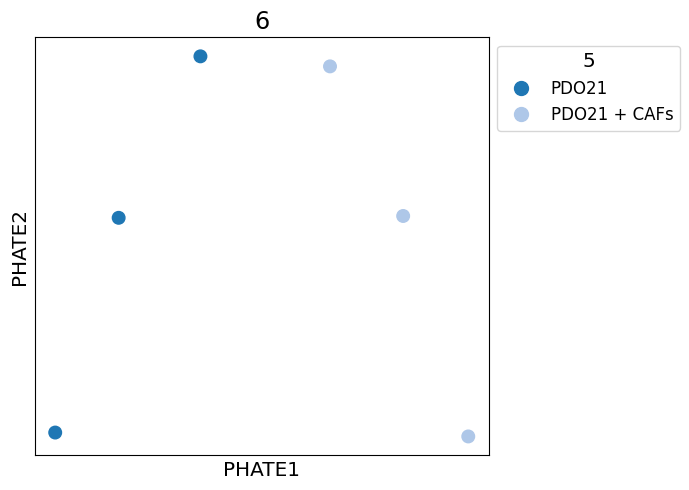

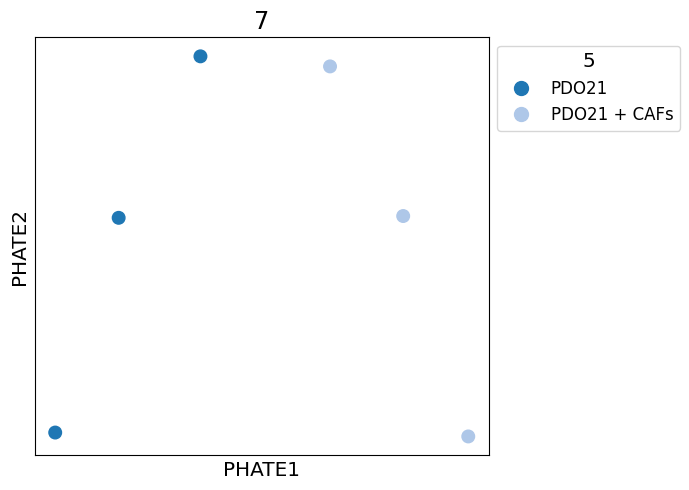

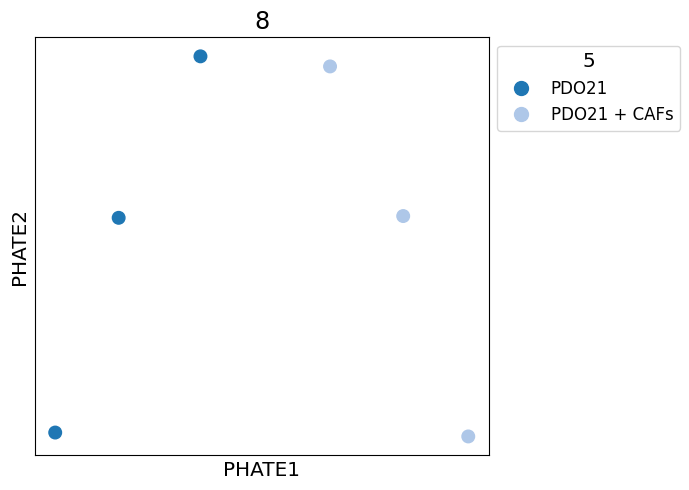

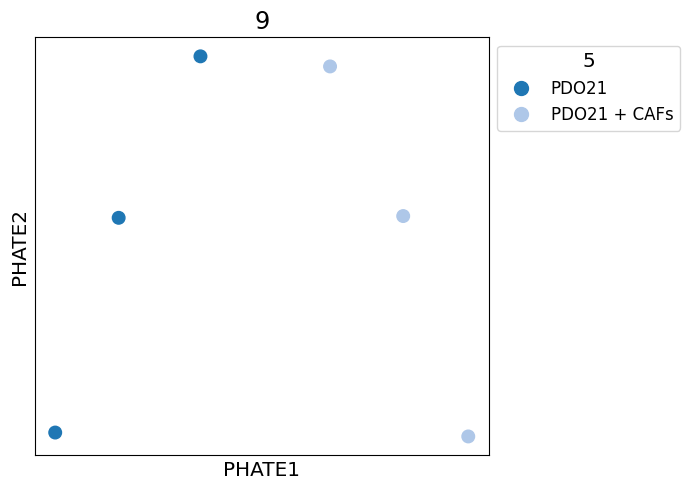

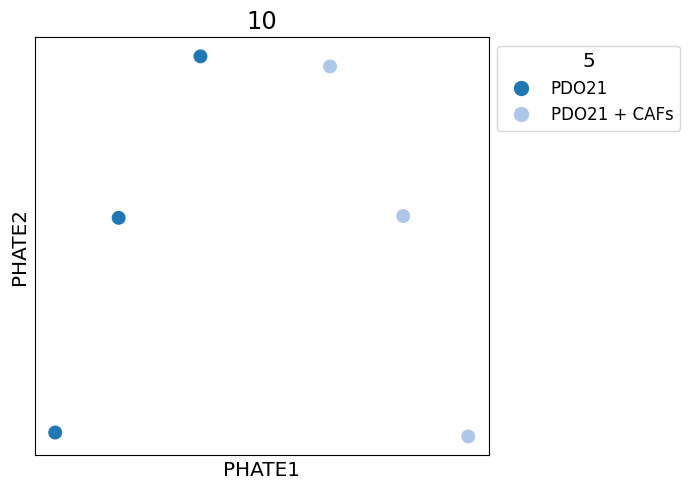

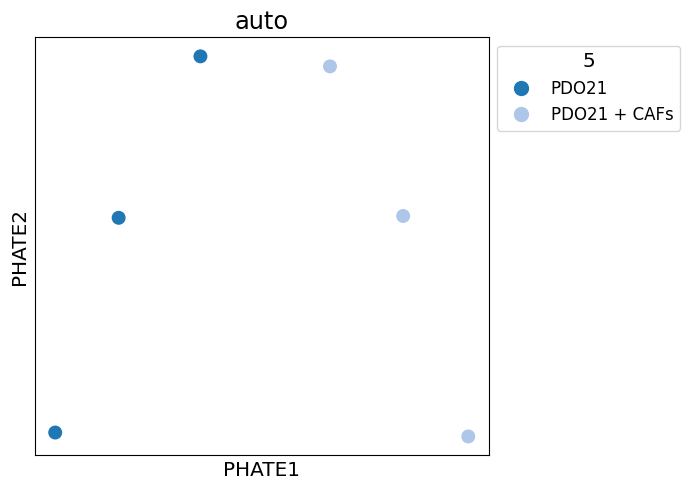

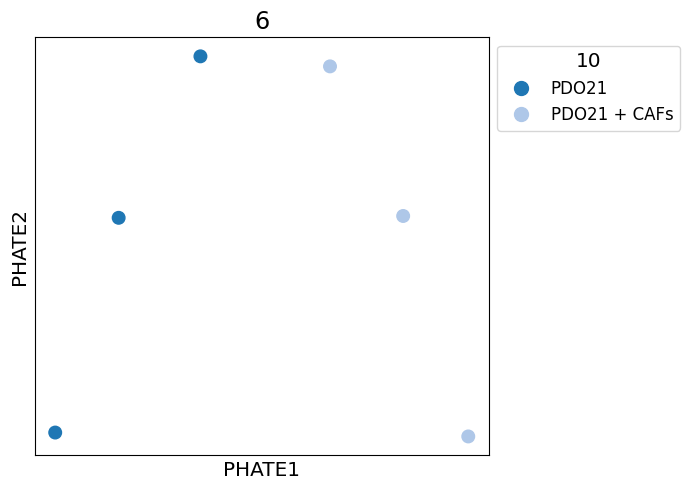

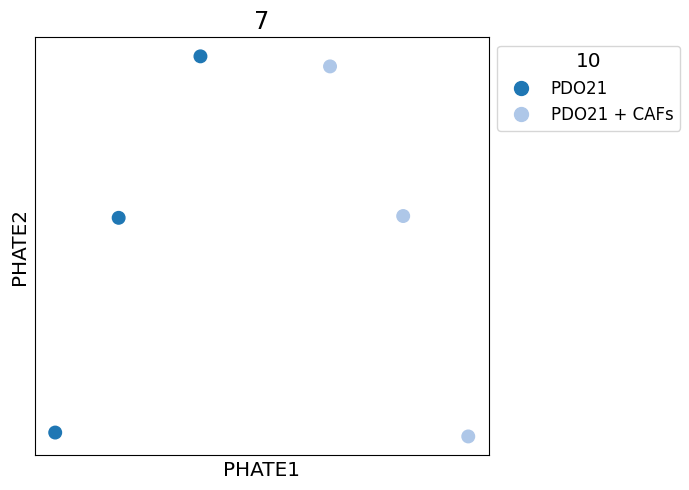

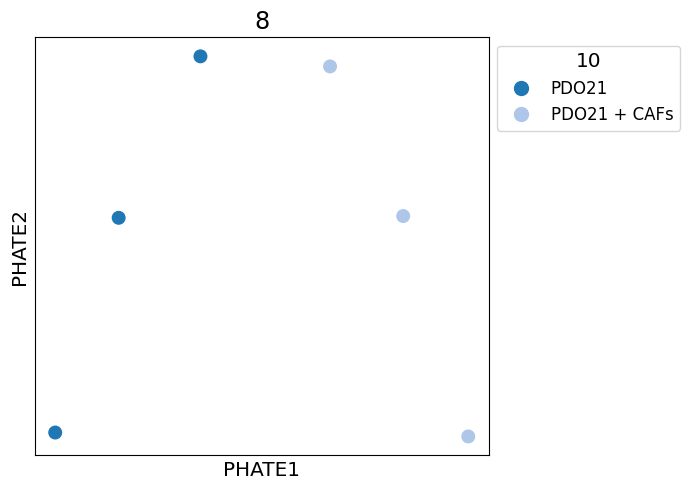

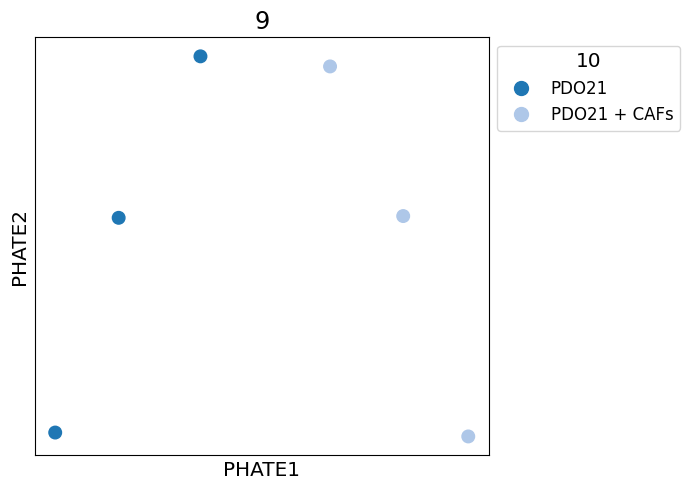

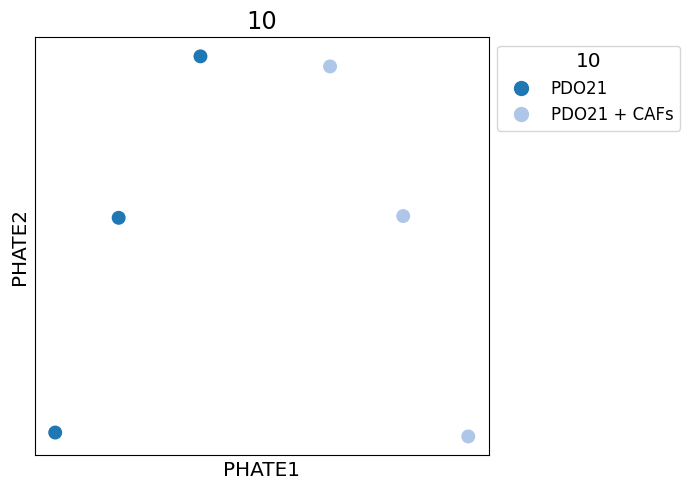

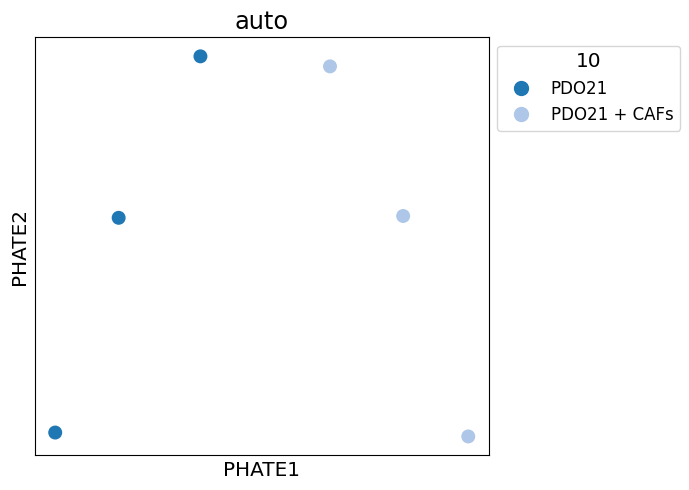

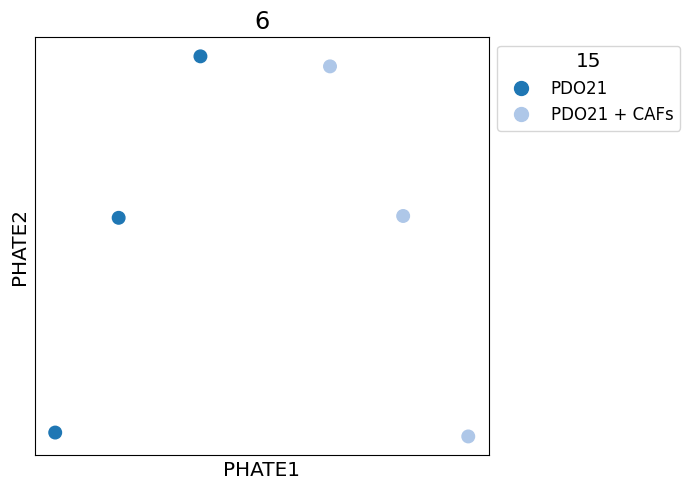

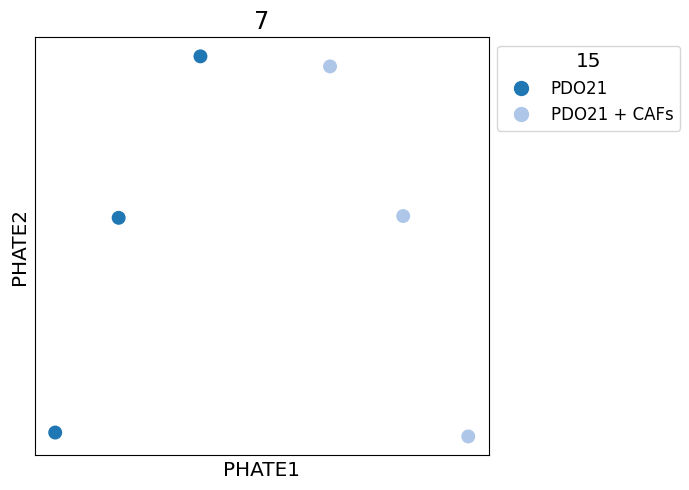

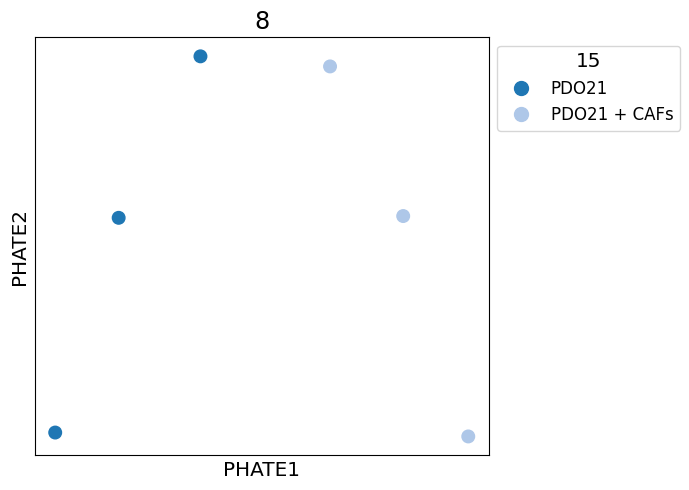

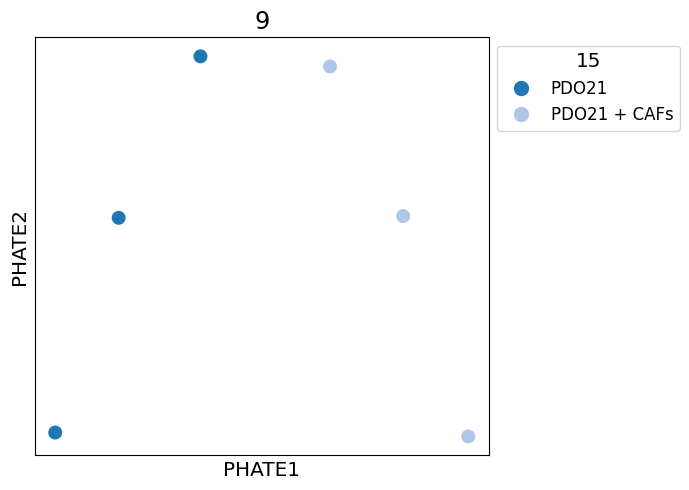

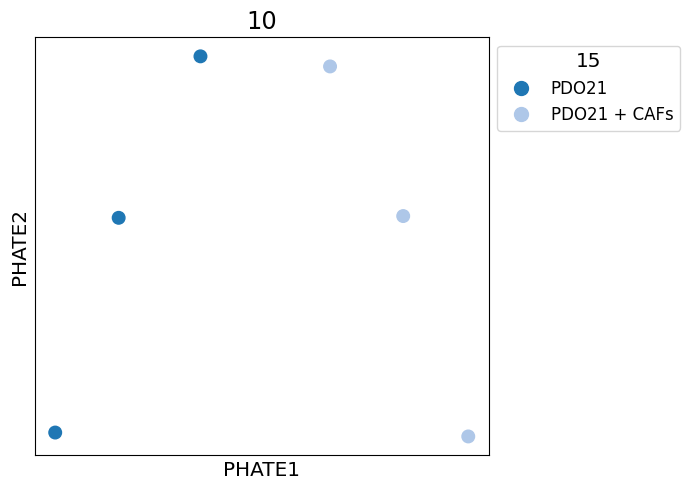

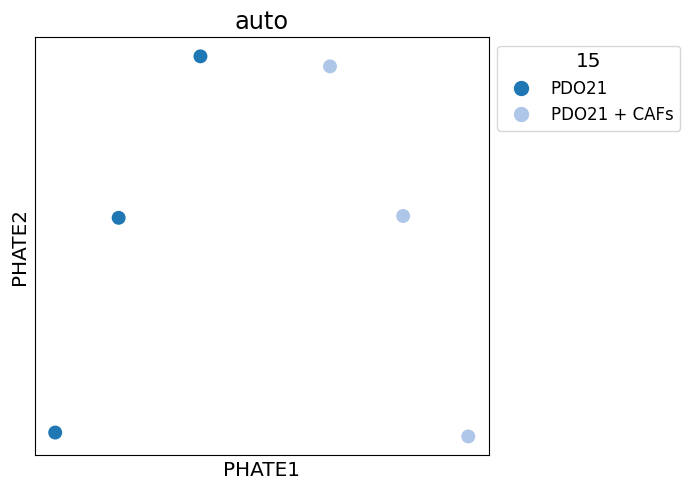

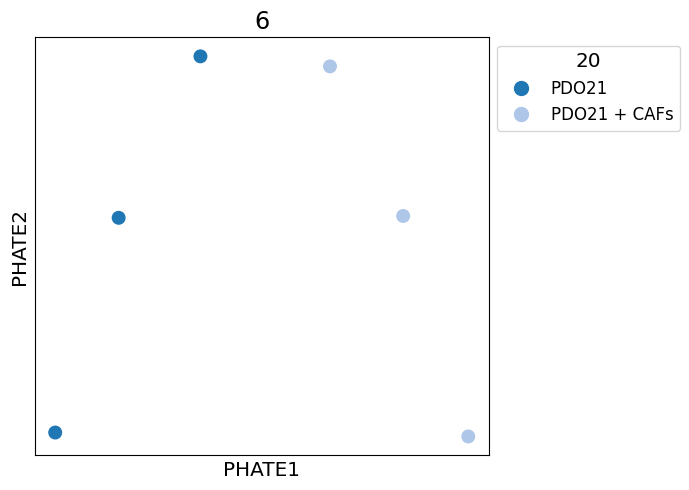

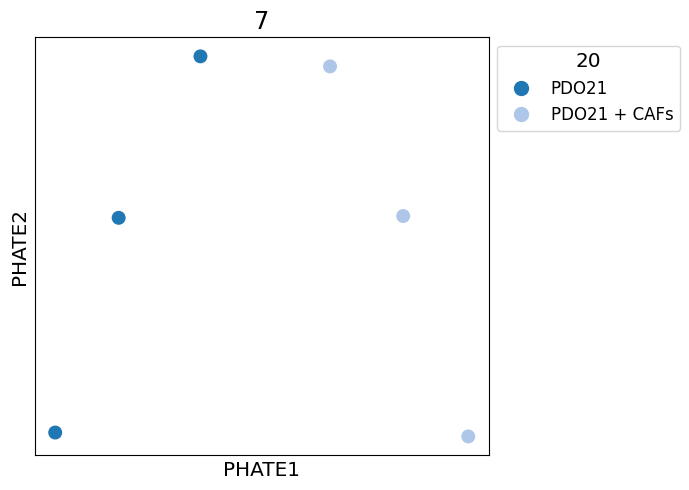

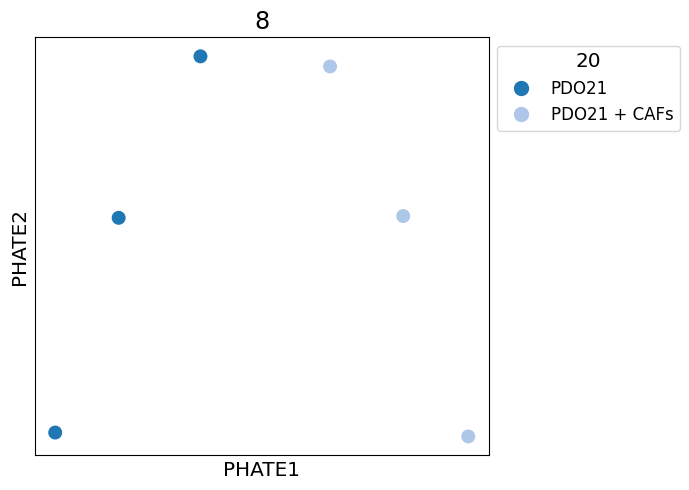

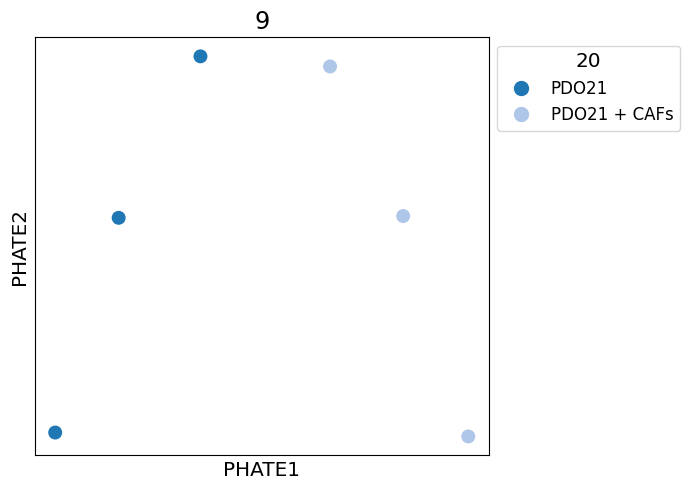

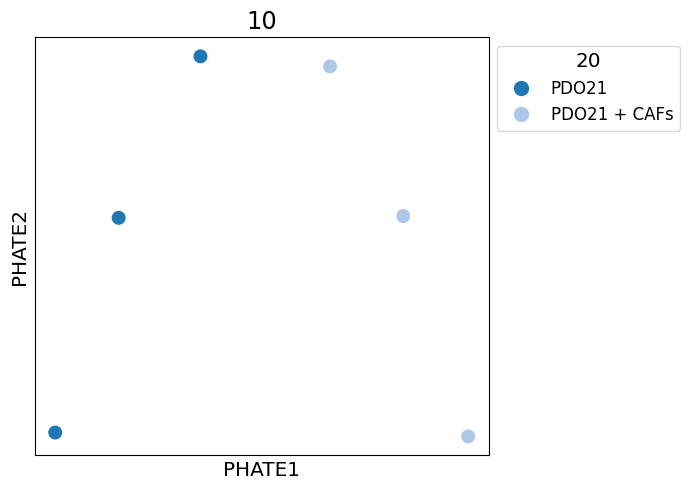

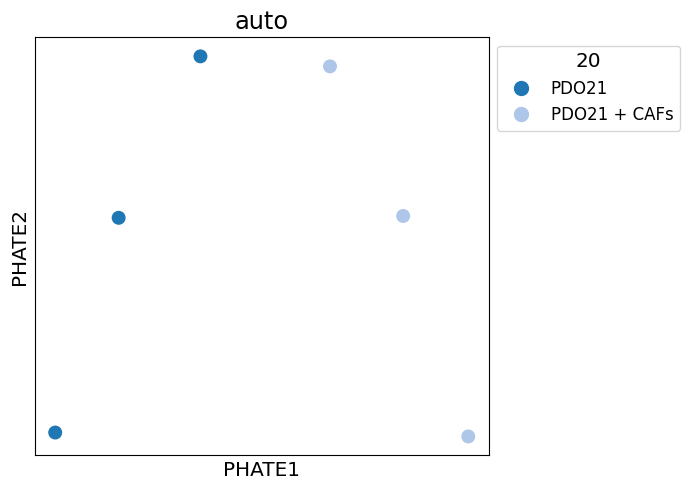

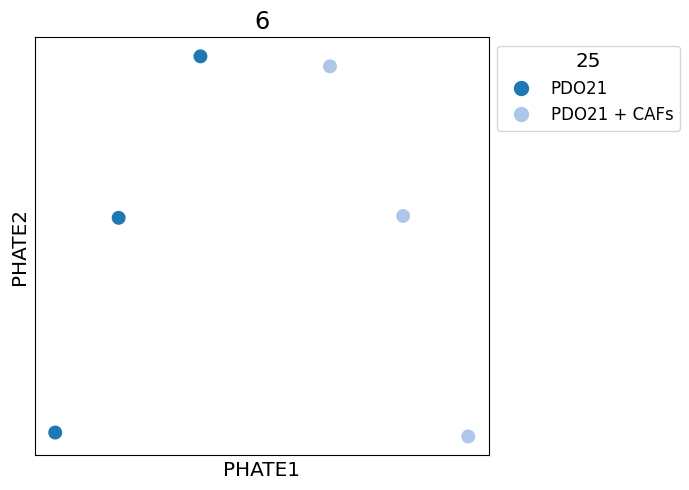

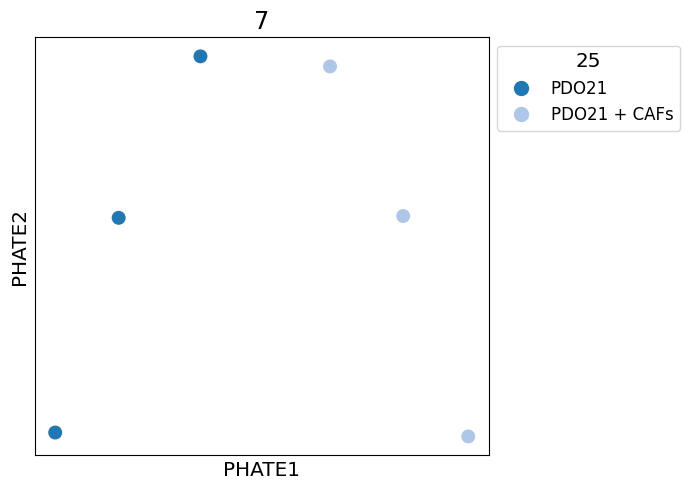

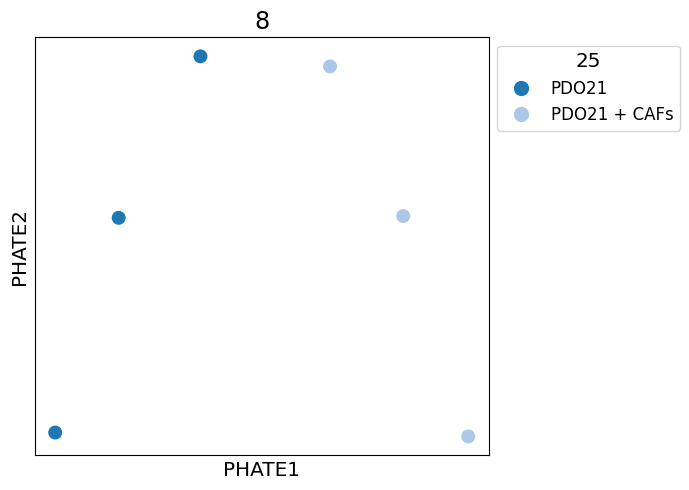

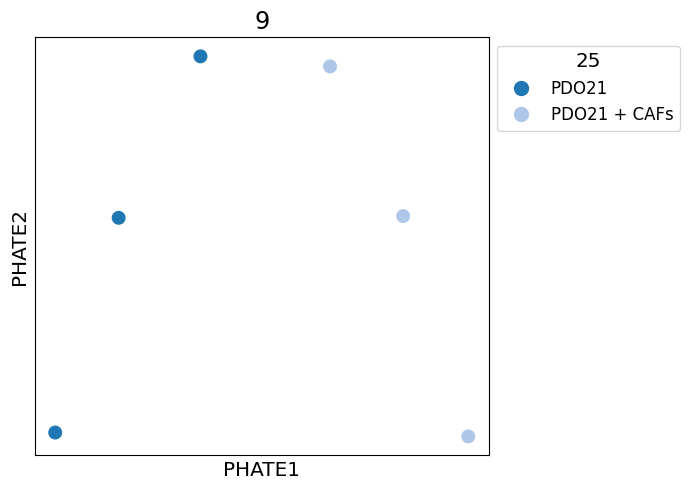

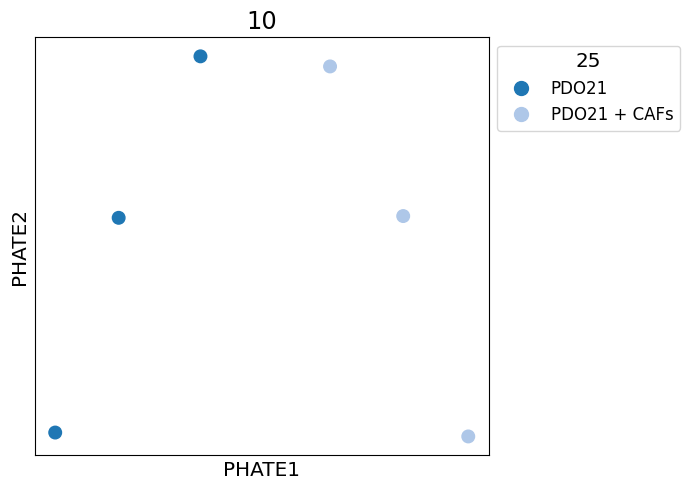

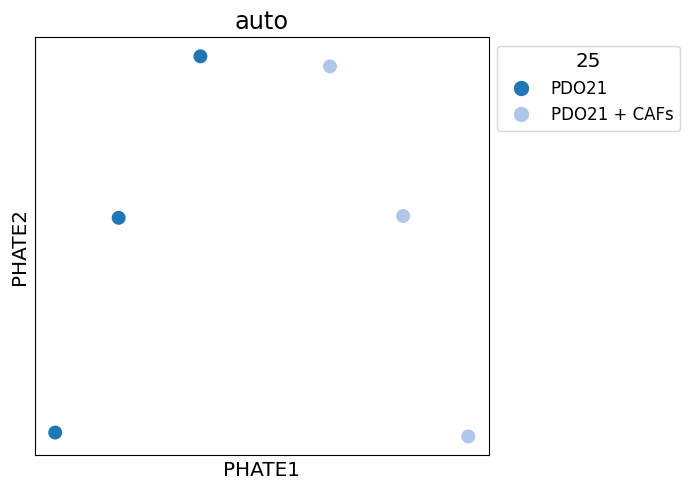

In [39]:
import phate
import pandas as pd
import scprep

# For each K-nearest neighboors
for knn in KNNs: 
    # For each level of diffusion
    for t in Ts: 
        # Define the phate operator with its parameters
        # Use of 'smacof' mds_solver as the 'sgd' default doesn't work
        phate_op = phate.PHATE(random_state = random_state, knn = knn, t=t,
                               mds_solver='smacof', n_jobs=-2, verbose=False)
        
        # Make the phate operator (phate_op) transform the dataframe into an array with 2 columns containing the PHATE coordinates for each condition. 
        data_phate = phate_op.fit_transform(filtered_data)
        data_phate = pd.DataFrame(data_phate, index=filtered_data.index)

        scprep.plot.scatter2d(data_phate, c=condition_values, cmap='tab20',
                      ticks=False, label_prefix='PHATE',
                      legend_anchor=(1,1), figsize=(7,5), title=t, legend_title=knn)